In [4]:
import numpy as np
import pandas as pd
import os, re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from itertools import chain
from nltk.tokenize import TweetTokenizer
import spacy
from spacy import displacy
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime

In [5]:
#Reading the data into one dataframe 'dfs'
dfs = pd.DataFrame()
for fname in os.listdir():
    if re.search(r'\.xlsx$', fname):
        print(fname)
        df=pd.read_excel(fname)
        df.drop(df.tail(10).index, inplace = True) 
        dfs = dfs.append(df) 

Stream (8).xlsx
Stream (2) (1).xlsx
Stream (9).xlsx
Stream (5).xlsx
Stream (11).xlsx
Stream (7).xlsx
Stream (3).xlsx
Stream (10).xlsx
Stream (6).xlsx
Stream (4).xlsx
T Only 3_1_2017 thru 6_30_2017 Random Stream (1).xlsx
T Only 9_1_2017 thru 10_31_2017 Random Stream (1).xlsx


In [3]:
#Initial data understanding
print("Dataframe Shape",dfs.shape)
dfs.tail(2)

Dataframe Shape (512701, 41)


,Post ID,Sound Bite Text,Ratings and Scores,Title,Source Type,Post Type,Media Type,URL,Domain,Published Date (GMT-04:00) New York,...,Quoted Author Handle,Total Engagements,Post Comments,Post Likes,Post Shares,Post Views,Post Dislikes,Product Name,Product Hierarchy,Rating
19528,911598117337706497,RT @lizarivera216: Iphone 8 Launch at The Foru...,NaN,NaN,Twitter,Retweets and Reblogs,Image,http://twitter.com/sarahwhite0331/statuses/911...,twitter.com,"Sep 23, 2017 10:28:22 AM",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19529,"If your topic is scaled to 100%, the number of...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Data Cleaning
#Collecting columns where more than 80% data is present
df = dfs.loc[:, dfs.isnull().mean() < .8]
print("Dataframe Shape after eliminating columns that have more than 80% null values:",df.shape)
#Removing Duplicate data
df=df.drop_duplicates()
#selecting only Original posts.
df = df[df['Post Type'].notna()]
df = df[df['Post Type'].str.contains("Original")]
#Removing all columns with NaN values
df = df.dropna(how = 'all')      
print("Dataframe Shape after eliminating columns with null values:",df.shape)
#Taking data from only reliable sources
df = df[df.Domain.notnull()]
print("Dataframe Shape after eliminating unreliable sources:",df.shape)
#Filtering Authors/Celebrities
#Reference: 
df= df[df['No. of Followers/Daily Unique Visitors']<9000]
print("Dataframe Shape after eliminating posts from authors and celebrities:",df.shape)

Dataframe Shape after eliminating columns that have more than 80% null values: (512701, 18)
Dataframe Shape after eliminating columns with null values: (409753, 18)
Dataframe Shape after eliminating unreliable sources: (409753, 18)
Dataframe Shape after eliminating posts from authors and celebrities: (389023, 18)


In [7]:
#Data Preparation
#Processing String Column 'Sound Bite Text'
df['Soundtext'] = df['Sound Bite Text'].str.lower()
#Extracting information about three products - assigning each row in the dataframe to one of the three labels respectively
#Label 0: iPhone X
#Lable 1: iPhone 8
#Label 2: Samsung Galaxy S8
#Label 3: Any other product
df['Label'] = 1000
a="iphonex"
d="iphone x"
b="iphone8"
e="iphone 8"
c="galaxy s8"
for i in range(0,len(df)):
    if a in df.iloc[i,18] or d in df.iloc[i,18]:
        df.iloc[i,19] = 0
    elif b in df.iloc[i,18] or e in df.iloc[i,18]:
        df.iloc[i,19] = 1
    elif c in df.iloc[i,18]:
        df.iloc[i,19] = 2
    else:
        df.iloc[i,19] = 3

In [8]:
print("#Reviews for iPhoneX",len(df[df.Label == 0]))
print("#Reviews for iPhone8",len(df[df.Label == 1]))
print("#Reviews for Galaxy S8",len(df[df.Label == 2]))
print("#Reviews for Other Products",len(df[df.Label == 3]))

#Reviews for iPhoneX 49576
#Reviews for iPhone8 145234
#Reviews for Galaxy S8 193928
#Reviews for Other Products 285


In [9]:
#Extracting information for iPhone X, iPhone 8, and Samsung Galaxy S8
df1=df[(df['Label'] == 0) | (df['Label'] == 1) | (df['Label']==2)]

In [10]:
#Cleaning the review data: removing stopwords, punctuations and digits
stop = stopwords.words('english')
df1['text'] = df1['Soundtext'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop) and len(word.lower())>2]))
df1['text'] = df1['text'].str.replace('[^\w\s]','')
df1['text'] = df1['text'].str.replace('\d+','')

<ipython-input-10-8f73d189ec76>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['text'] = df1['Soundtext'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop) and len(word.lower())>2]))
<ipython-input-10-8f73d189ec76>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['text'] = df1['text'].str.replace('[^\w\s]','')
<ipython-input-10-8f73d189ec76>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [8]:
#defining function to generate wordlist for wordclouds and further processing
def generateWordlist(wordlist):
    wordlist = list(chain.from_iterable(wordlist))
    extrawords = ['iphone','galaxy','samsung','phone','iphones','android','smartphone','plus','year','phones','samsungs','note','device','google','apple','apples','time','day','work','date','way','flag','irrelevant','today','use','thing','watch','series','will','still','set','last','company','include','offer','now','new','product','feature','brand','one', '...']
    wordlist = [word for word in wordlist if word not in extrawords and len(word)>2]
    wordlistStem = []
    wordlistLem = []
    ps = PorterStemmer() 
    for w in wordlist: 
        wordlistStem.append(ps.stem(w))
    lemmatizer = WordNetLemmatizer() 
    for w in wordlistStem: 
        wordlistLem.append(lemmatizer.lemmatize(w))
    return wordlistLem

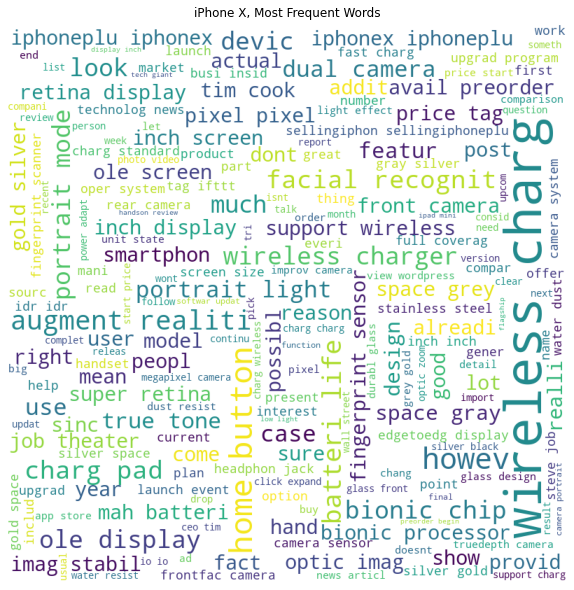

In [89]:
#iPhoneX: finding the most common words in reviews for this product. Here, we also perform POS tagging, such that we 
#can find the most frequently occuring nouns and adjectives in reviews of iPhoneX. 
listiPhoneX = df1.text[df1['Label'] == 0].apply(lambda x: word_tokenize(x.lower()))
wordlistX = generateWordlist(listiPhoneX)
taggedListX = nltk.pos_tag(wordlistX) 
nounsAdjsListX = [word for word,pos in taggedListX if (pos == 'NN' or pos == 'JJ' )]
wordsX = ' '.join(nounsAdjsListX)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(wordsX)                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("iPhone X, Most Frequent Words")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 


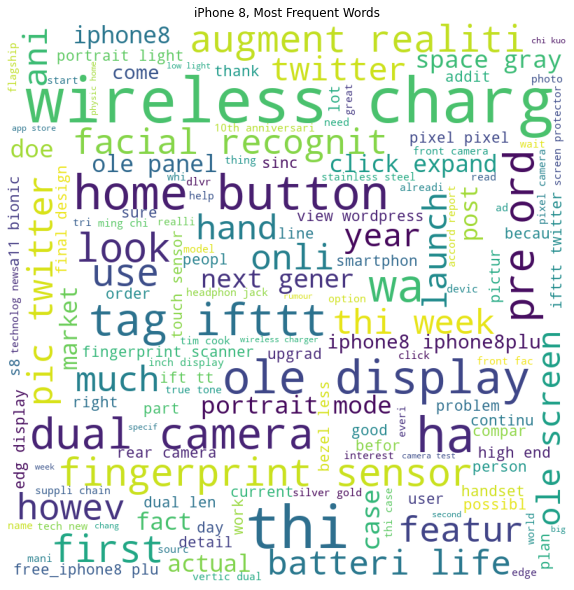

In [90]:
#iPhone 8: finding the most common words in reviews for this product. Here, we also perform POS tagging, such that we 
#can find the most frequently occuring nouns and adjectives in reviews of iPhone 8. 
listiPhone8 = df1.Soundtext[df1['Label'] == 1].apply(lambda x: word_tokenize(x.lower()))
wordlist8 = generateWordlist(listiPhone8)
taggedList8 = nltk.pos_tag(wordlist8) 
nounsList8 = [word for word,pos in taggedList8 if (pos == 'NN' or pos == 'JJ')]
words8 = ' '.join(nounsList8)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(words8)                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("iPhone 8, Most Frequent Words")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

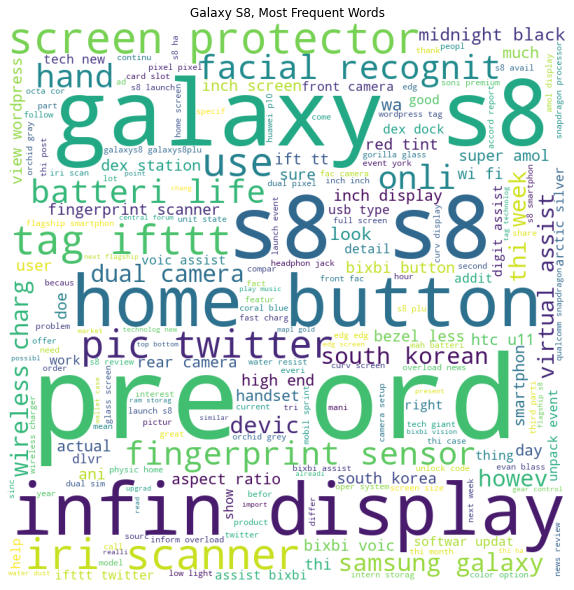

In [92]:
#Samsung S8: finding the most common words in reviews for this product. Here, we also perform POS tagging, such that 
#we can find the most frequently occuring nouns and adjectives in reviews of Samsung S8. 
listSamsung = df1.Soundtext[df1['Label'] == 2].apply(lambda x: word_tokenize(x.lower()))
wordlistS = generateWordlist(listSamsung)
taggedListS = nltk.pos_tag(wordlistS) 
nounsListS = [word for word,pos in taggedListS if (pos == 'NN' or pos == 'JJ')]
wordsS = ' '.join(nounsListS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(wordsS) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("Galaxy S8, Most Frequent Words")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [18]:
#Defining a function to compute the compound score of each review; so that we can label each review with its 
#associated sentiment
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(reviews):
    return analyser.polarity_scores(reviews)['compound']

In [19]:
#Computing the compound score for each review and storing that in a list named 'scores'
scores=[]
for i in range(0,len(df1)):
    scores.append([sentiment_analyzer_scores(df1.iloc[i,20])])
scores = list(chain.from_iterable(scores))

In [20]:
#Assigning the sentiment value to each review based on the compound score: 
#score > 0.5 labelled as 'pos'
#-0.5 < score < 0.5 labelled as 'neu'
#score < -0.5 labelled as 'neg'
df1['sentiment'] = ''
for i in range(0,len(scores)):
    if scores[i]>=0.5:
        df1.iloc[i,21] = 'pos'
    elif scores[i] > -0.5 and scores[i] < 0.5:
        df1.iloc[i,21] = 'neu'
    else:
        df1.iloc[i,21] = 'neg'

<ipython-input-20-f096bfdfd103>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['sentiment'] = ''
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [40]:
#defining plot function for QVP Analysis
def funcplot(fd,product,s):
    plt.figure(figsize=(20, 20))
    ax = fd.plot(kind='barh')
    if(s == "Quality" or s=="Price"):
        ax.set_title(product+', '+s)
    else:
        ax.set_title(product+', Features('+s+')')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Word')
    ax.set_yticklabels(fd["Word"])
    return ax

In [13]:
#Find positive reviews of iPhoneX and generate its corresponding wordlist
iPhoneXPos = df1.text[(df1['Label'] == 0) & (df1['sentiment'] == 'pos')].apply(lambda x: word_tokenize(x.lower()))
wordlistXPos = generateWordlist(iPhoneXPos)

<Figure size 1440x1440 with 0 Axes>

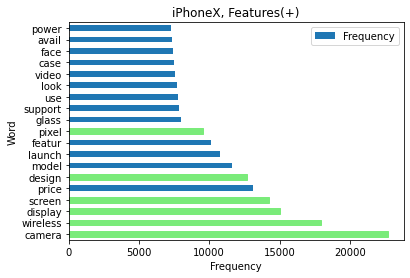

In [45]:
#Find the most frequent nouns and adjectives in the positive reviews of iPhoneX and plot them on a bar chart
taggedListXPos = nltk.pos_tag(wordlistXPos) 
featureListXPos = [word for word,pos in taggedListXPos if (pos == 'NN' or pos =='JJ')]
fdistXPos = nltk.FreqDist(featureListXPos)
fdXPos = pd.DataFrame(fdistXPos.most_common(20),                    \
     columns = ["Word","Frequency"]).drop([0]).reindex()
ax = funcplot(fdXPos,"iPhoneX",'+')
ax.get_children()[0].set_color('#7aeb7a')
ax.get_children()[1].set_color('#7aeb7a')
ax.get_children()[2].set_color('#7aeb7a')
ax.get_children()[3].set_color('#7aeb7a')
ax.get_children()[5].set_color('#7aeb7a')
ax.get_children()[9].set_color('#7aeb7a')

In [14]:
#Find negative reviews of iPhoneX and generate its corresponding wordlist
iPhoneXNeg = df1.text[(df1['Label'] == 0) & (df1['sentiment'] == 'neg')].apply(lambda x: word_tokenize(x.lower()))
wordlistXneg = generateWordlist(iPhoneXNeg)

<Figure size 1440x1440 with 0 Axes>

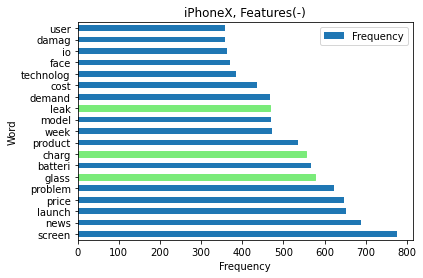

In [51]:
#Find the most frequent nouns and adjectives in the negative reviews of iPhoneX and plot them on a bar chart
taggedListXNeg = nltk.pos_tag(wordlistXneg) 
featureListXNeg = [word for word,pos in taggedListXNeg if (pos == 'NN' or pos =='JJ')]
fdistXNeg = nltk.FreqDist(featureListXNeg)
fdXNeg = pd.DataFrame(fdistXNeg.most_common(20),                    \
     columns = ["Word","Frequency"]).drop([0]).reindex()
ax = funcplot(fdXNeg,"iPhoneX",'-')
ax.get_children()[5].set_color('#7aeb7a')
ax.get_children()[7].set_color('#7aeb7a')
ax.get_children()[11].set_color('#7aeb7a')

In [15]:
#Find positive reviews of iPhone8 and generate its corresponding wordlist
iPhone8Pos = df1.text[(df1['Label'] == 1) & (df1['sentiment'] == 'pos')].apply(lambda x: word_tokenize(x.lower()))
wordlist8Pos = generateWordlist(iPhone8Pos)

<Figure size 1440x1440 with 0 Axes>

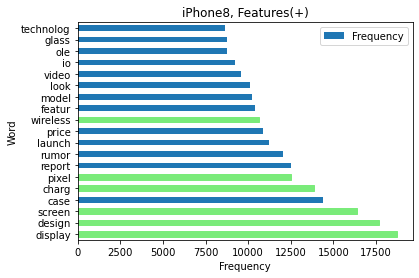

In [53]:
#Find the most frequent nouns and adjectives in the positive reviews of iPhone8 and plot them on a bar chart
taggedList8Pos = nltk.pos_tag(wordlist8Pos) 
featureList8Pos = [word for word,pos in taggedList8Pos if (pos == 'NN' or pos=='JJ')]
fdist8Pos = nltk.FreqDist(featureList8Pos)
fd8Pos = pd.DataFrame(fdist8Pos.most_common(20),                    \
    columns = ["Word","Frequency"]).drop([0]).reindex()
ax = funcplot(fd8Pos,"iPhone8",'+')
ax.get_children()[0].set_color('#7aeb7a')
ax.get_children()[1].set_color('#7aeb7a')
ax.get_children()[2].set_color('#7aeb7a')
ax.get_children()[4].set_color('#7aeb7a')
ax.get_children()[5].set_color('#7aeb7a')
ax.get_children()[10].set_color('#7aeb7a')

In [16]:
#Find negative reviews of iPhone8 and generate its corresponding wordlist
iPhone8Neg = df1.text[(df1['Label'] == 1) & (df1['sentiment'] == 'neg')].apply(lambda x: word_tokenize(x.lower()))
wordlist8Neg = generateWordlist(iPhone8Neg)

<Figure size 1440x1440 with 0 Axes>

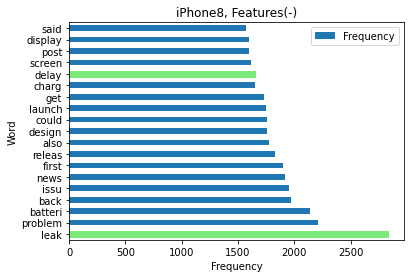

In [71]:
# #Find the most frequent nouns and adjectives in the negative reviews of iPhone8 and plot them on a bar chart
taggedList8Neg = nltk.pos_tag(wordlist8Neg) 
featureList8Neg = [word for word,pos in taggedList8Neg if (pos == 'NN' or pos=='JJ')]
fdist8Neg = nltk.FreqDist(wordlist8Neg)
fd8Neg = pd.DataFrame(fdist8Neg.most_common(20),                    \
    columns = ["Word","Frequency"]).drop([0]).reindex()
ax = funcplot(fd8Neg,"iPhone8",'-')
ax.get_children()[0].set_color('#7aeb7a')
ax.get_children()[14].set_color('#7aeb7a')


In [17]:
#Find positive reviews of Galaxy S8 and generate its corresponding wordlist
SamsungPos = df1.text[(df1['Label'] == 2) & (df1['sentiment'] == 'pos')].apply(lambda x: word_tokenize(x.lower()))
wordlistSamsungPos = generateWordlist(SamsungPos)

<Figure size 1440x1440 with 0 Axes>

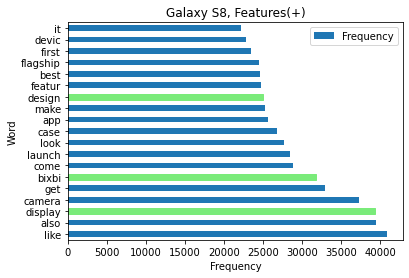

In [74]:
#Find the most frequent nouns and adjectives in the positive reviews of Galaxy S8 and plot them on a bar chart
taggedListSamsungPos = nltk.pos_tag(wordlistSamsungPos) 
featureListSamsungPos = [word for word,pos in taggedListSamsungPos if (pos == 'NN' or pos=='JJ')]
fdistSamsungPos = nltk.FreqDist(wordlistSamsungPos)
fdSamsungPos = pd.DataFrame(fdistSamsungPos.most_common(20),                    \
    columns = ["Word","Frequency"]).drop([0]).reindex()
ax = funcplot(fdSamsungPos,"Galaxy S8",'+')
ax.get_children()[2].set_color('#7aeb7a')
ax.get_children()[3].set_color('#7aeb7a')
ax.get_children()[5].set_color('#7aeb7a')
ax.get_children()[12].set_color('#7aeb7a')

In [18]:
#Find negative reviews of Galaxy S8 and generate its corresponding wordlist
SamsungNeg = df1.text[(df1['Label'] == 2) & (df1['sentiment'] == 'neg')].apply(lambda x: word_tokenize(x.lower()))
wordlistSamsungNeg = generateWordlist(SamsungNeg)

<Figure size 1440x1440 with 0 Axes>

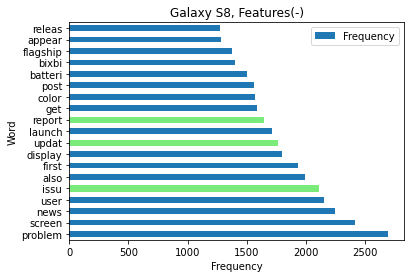

In [75]:
# #Find the most frequent nouns and adjectives in the negative reviews of Galaxy S8 and plot them on a bar chart
taggedListSamsungNeg = nltk.pos_tag(wordlistSamsungNeg) 
featureListSamsungNeg = [word for word,pos in taggedListSamsungNeg if (pos == 'NN' or pos=='JJ')]
fdistSamsungNeg = nltk.FreqDist(wordlistSamsungNeg)
fdSamsungNeg = pd.DataFrame(fdistSamsungNeg.most_common(20),                    \
    columns = ["Word","Frequency"]).drop([0]).reindex()
ax = funcplot(fdSamsungNeg,"Galaxy S8",'-')
ax.get_children()[4].set_color('#7aeb7a')
ax.get_children()[8].set_color('#7aeb7a')
ax.get_children()[10].set_color('#7aeb7a')

In [103]:
#Quality Analysis
#Find the number of positive and negative reviews of iPhoneX to check if there is a class imbalance problem. 
#Perform undersampling, if the class imbalance problem exists
print("iPhoneX, Reviews(+)",len(iPhoneXPos))
print("iPhoneX, Review(-)",len(iPhoneXNeg))
if(len(iPhoneXPos)>len(iPhoneXNeg) or len(iPhoneXPos)<len(iPhoneXNeg)):
    print("Class imbalance problem")
iPhoneXPos1 = iPhoneXPos.sample(n = len(iPhoneXNeg)) 

iPhoneX, Reviews(+) 27590
iPhoneX, Review(-) 3154
Class imbalance problem


<Figure size 1440x1440 with 0 Axes>

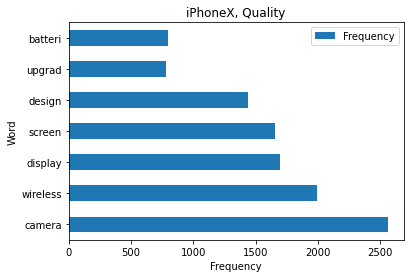

In [115]:
#Generate wordlist for the undersampled positive reviews of iPhoneX
#We have formulated a set of features that describe the quality of a product(this is our assumption)
#Then, we plot a bar chart to see the frequency of these features being mentioned in the positive reviews
wordlistXPos1 = generateWordlist(iPhoneXPos1)
qualityListXPos1 = ['camera','wireless', 'display','screen', 'design','upgrad','batteri']
aXPos1 = {i:wordlistXPos1.count(i) for i in qualityListXPos1}
fdXPos1 = pd.DataFrame(aXPos1.items(), columns=['Word', 'Frequency'])
funcplot(fdXPos1,"iPhoneX","Quality")

In [64]:
#Find the number of positive and negative reviews of iPhone8 to check if there is a class imbalance problem
#Perform undersampling, if the class imbalance problem exists
print("iPhone8, Reviews(+)",len(iPhone8Pos))
print("iPhone8, Review(-)",len(iPhone8Neg))
if(len(iPhone8Pos)>len(iPhone8Neg) or len(iPhone8Pos)<len(iPhone8Neg)):
    print("Class imbalance problem")
iPhone8Pos1 = iPhone8Pos.sample(n = len(iPhone8Neg)) 

iPhone8, Reviews(+) 58274
iPhone8, Review(-) 8645
Class imbalance problem


<Figure size 1440x1440 with 0 Axes>

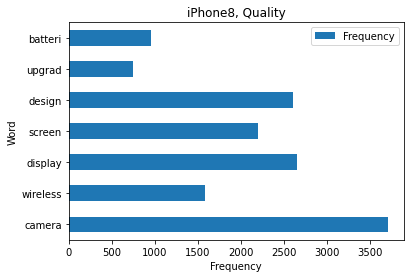

In [65]:
#Generate wordlist for the undersampled positive reviews of iPhone8
#We have formulated a set of features that describe the quality of a product(this is our assumption)
#Then, we plot a bar chart to see the frequency of these features being mentioned in the positive reviews
wordlist8Pos1 = generateWordlist(iPhone8Pos1)
taggedList8Pos1 = nltk.pos_tag(wordlist8Pos1) 
featureList8Pos1 = [word for word,pos in taggedList8Pos1 if (pos == 'NN' or pos=='JJ')]
qualityList8Pos1 = ['camera','wireless', 'display','screen', 'design','upgrad','batteri']
a8Pos1 = {i:featureList8Pos1.count(i) for i in qualityList8Pos1}
fd8Pos1 = pd.DataFrame(a8Pos1.items(), columns=['Word', 'Frequency'])
funcplot(fd8Pos1,"iPhone8","Quality")

In [60]:
#Find the number of positive and negative reviews of Galaxy S8 to check if there is a class imbalance problem
#Perform undersampling, if the class imbalance problem exists
print("Galaxy S8, Reviews(+)",len(SamsungPos))
print("Galaxy S8, Review(-)",len(SamsungNeg))
if(len(SamsungPos)>len(SamsungNeg) or len(SamsungPos)<len(SamsungNeg)):
    print("Class imbalance problem")
SamsungPos1 = SamsungPos.sample(n = len(SamsungNeg)) 

Galaxy S8, Reviews(+) 90833
Galaxy S8, Review(-) 9156
Class imbalance problem


<Figure size 1440x1440 with 0 Axes>

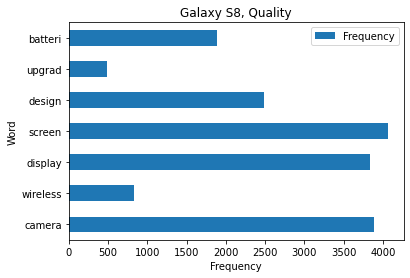

In [61]:
# Generate wordlist for the undersampled positive reviews of Samsung Galaxy S8
#We have formulated a set of features that describe the quality of a product(this is our assumption)
#Then, we plot a bar chart to see the frequency of these features being mentioned in the positive reviews
wordlistSamsungPos1 = generateWordlist(SamsungPos1)
taggedListSamsungPos1 = nltk.pos_tag(wordlistSamsungPos1) 
featureListSamsungPos1 = [word for word,pos in taggedListSamsungPos1 if (pos == 'NN' or pos=='JJ')]
qualityListSamsungPos1 = ['camera','wireless', 'display','screen', 'design','upgrad','batteri']
aSamsungPos1 = {i:featureListSamsungPos1.count(i) for i in qualityListSamsungPos1}
fdSamsungPos1 = pd.DataFrame(aSamsungPos1.items(), columns=['Word', 'Frequency'])
funcplot(fdSamsungPos1,"Galaxy S8","Quality")

<Figure size 1440x1440 with 0 Axes>

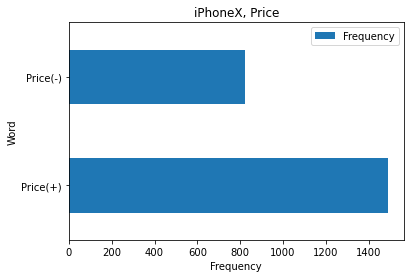

In [124]:
#Price Analysis
#iPhoneX
qualityListXPos1P = ['price']
aXPos1P = {i:featureListXPos1.count(i) for i in qualityListXPos1P}
qualityListXNegP = ['price']
aXNegP = {i:featureListXNeg.count(i) for i in qualityListXNegP}
oneXPrice = aXPos1P.get("price")
twoXPrice = aXNegP.get("price")
dicXPrice = {"Price(+)":oneXPrice, "Price(-)":twoXPrice} 
fdXPrice = pd.DataFrame(dicXPrice.items(), columns=['Word', 'Frequency'])
funcplot(fdXPrice,"iPhoneX","Price")

<Figure size 1440x1440 with 0 Axes>

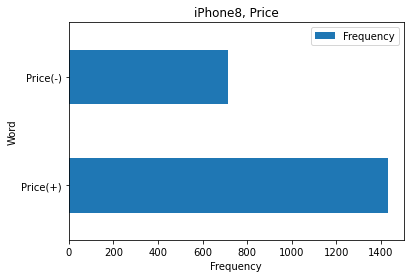

In [66]:
#Price Analysis
#iPhone8
qualityList8Pos1P = ['price']
a8Pos1P = {i:featureList8Pos1.count(i) for i in qualityList8Pos1P}
qualityList8NegP = ['price']
a8NegP = {i:featureList8Neg.count(i) for i in qualityList8NegP}
one8Price = a8Pos1P.get("price")
two8Price = a8NegP.get("price")
dic8Price = {"Price(+)":one8Price, "Price(-)":two8Price} 
fd8Price = pd.DataFrame(dic8Price.items(), columns=['Word', 'Frequency'])
funcplot(fd8Price,"iPhone8","Price")

<Figure size 1440x1440 with 0 Axes>

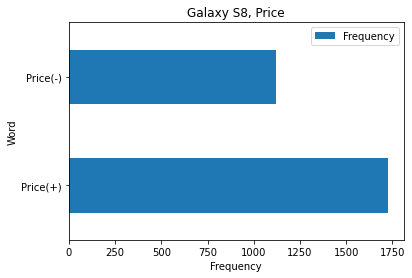

In [67]:
#Price Analysis
#Galaxy S8
qualityListSamsungPos1P = ['price']
aSamsungPos1P = {i:featureListSamsungPos1.count(i) for i in qualityListSamsungPos1P}
qualityListSamsungNegP = ['price']
aSamsungNegP = {i:featureListSamsungNeg.count(i) for i in qualityListSamsungNegP}
oneSamsungPrice = aSamsungPos1P.get("price")
twoSamsungPrice = aSamsungNegP.get("price")
dicSamsungPrice = {"Price(+)":oneSamsungPrice, "Price(-)":twoSamsungPrice} 
fdSamsungPrice = pd.DataFrame(dicSamsungPrice.items(), columns=['Word', 'Frequency'])
funcplot(fdSamsungPrice,"Galaxy S8","Price")

In [19]:
#Value Analysis: We take the value of a product as an overall sentiment associated with it. 
#We find compound scores for each of the products and store it in three separate lists
scores0 = []
scores1 = []
scores2 = []
for i in range(0,len(scores)):
    if df1.iloc[i,19]==0:
        scores0.append(scores[i])
    elif df1.iloc[i,19]==1:
        scores1.append(scores[i])
    else:
        scores2.append(scores[i])   

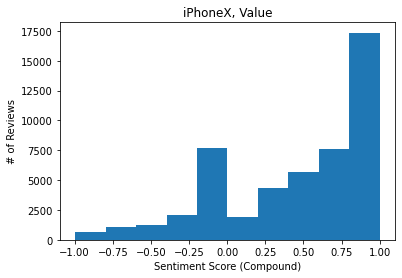

In [20]:
#Plotting a histogram of scores for iPhoneX
plt.hist(scores0)
plt.title("iPhoneX, Value")
plt.xlabel('Sentiment Score (Compound)')
plt.ylabel('# of Reviews')
plt.show()

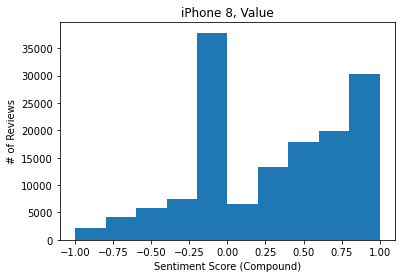

In [21]:
#Plotting a histogram of scores for iPhone8
plt.hist(scores1)
plt.title("iPhone 8, Value")
plt.xlabel('Sentiment Score (Compound)')
plt.ylabel('# of Reviews')
plt.show()

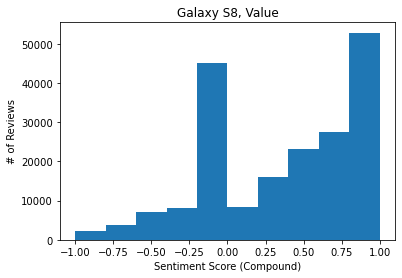

In [22]:
#Plotting a histogram of scores for Galaxy S8
plt.hist(scores2)
plt.title("Galaxy S8, Value")
plt.xlabel('Sentiment Score (Compound)')
plt.ylabel('# of Reviews')
plt.show()

In [21]:
#Time Series Analysis
df1['scores']=scores
from datetime import datetime
df1['date']=df1['Published Date (GMT-04:00) New York'].apply(lambda x: datetime.strptime(x,"%b %d, %Y %I:%M:%S %p"))
from datetime import datetime
galaxy_s8_date=datetime(2017,3,29)
iphone_8=datetime(2017,9,22)
iphone_x=datetime(2017,9,22)

<ipython-input-21-256e8e7e8a9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['scores']=scores
<ipython-input-21-256e8e7e8a9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date']=df1['Published Date (GMT-04:00) New York'].apply(lambda x: datetime.strptime(x,"%b %d, %Y %I:%M:%S %p"))


In [22]:
#Defining a function to plot the sentiment before and after launch
def plot_sentiment(df1,x):
    Tdates= pd.to_datetime(df1.date)
    per = Tdates.dt.to_period("D")
    g = df1.groupby(per)
    dates = [str(s) for s in list(g.mean().index)]
   
    ax=g.mean()['scores'].plot.line()
    ax.axvline(x, color='k', linestyle='--')

IPHONE X SENTIMENT :
Average sentiment score before release: 0.474234115120637
Average sentiment score after release: 0.45641824517927265


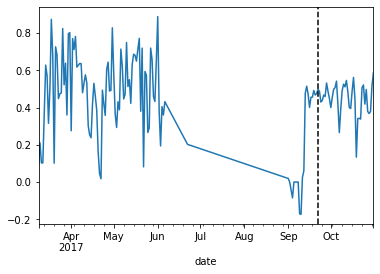

In [23]:
#iphone X sentiment
print("IPHONE X SENTIMENT :")
score_before = df1.loc[(df1['date']<iphone_x) & (df1['Label']==0)].scores.mean()
print("Average sentiment score before release:",score_before)

score_after = df1.loc[(df1['date']>iphone_x) & (df1['Label']==0)].scores.mean()
print("Average sentiment score after release:",score_after)

plot_sentiment(df1[df1['Label']==0],iphone_x)

IPHONE 8 SENTIMENT :
Average sentiment score before release: 0.3067379387113743
Average sentiment score after release: 0.31287983948971


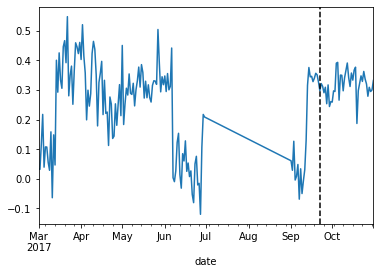

In [29]:
#iphone 8 sentiment
print("IPHONE 8 SENTIMENT :")
score_before = df1.loc[(df1['date']<iphone_8) & (df1['Label']==1)].scores.mean()
print("Average sentiment score before release:",score_before)

score_after = df1.loc[(df1['date']>iphone_8) & (df1['Label']==1)].scores.mean()
print("Average sentiment score after release:",score_after)

plot_sentiment(df1[df1['Label']==1],iphone_8)

SAMSUNG GALAXY SENTIMENT :
Average sentiment score before release: 0.23384873981740126
Average sentiment score after release: 0.3949362080450494


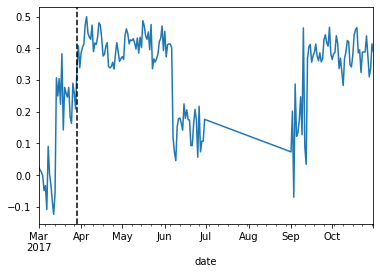

In [68]:
#galaxy_s8 sentiment
print("SAMSUNG GALAXY SENTIMENT :")
score_before = df1.loc[(df1['date']<galaxy_s8_date) & (df1['Label']==2)].scores.mean()
print("Average sentiment score before release:",score_before)

score_after = df1.loc[(df1['date']>galaxy_s8_date) & (df1['Label']==2)].scores.mean()
print("Average sentiment score after release:",score_after)

plot_sentiment(df1[df1['Label']==2],galaxy_s8_date)

In [30]:
#Comparing the obtained results from Vader with Textblob
! pip install -U textblob

! python -m textblob.download_corpora

     |████████████████████████████████| 636 kB 554 kB/s eta 0:00:01
[nltk_data] Downloading package brown to /Users/apple/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /Users/apple/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [24]:
#defining text blob function
def sentiment_calc(text):
  # try:
  return TextBlob(text).sentiment

In [25]:
df1['scores2']=df1['text'].apply(lambda x :sentiment_calc(x)[0])

<ipython-input-25-b712a336bdd6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['scores2']=df1['text'].apply(lambda x :sentiment_calc(x)[0])


In [26]:
#defining pot function for text blob
def plot_sentiment2(df1,x):
    Tdates= pd.to_datetime(df1.date)
    per = Tdates.dt.to_period("D")
    g = df1.groupby(per)
    dates = [str(s) for s in list(g.mean().index)]
   
    ax=g.mean()['scores2'].plot.line()
    ax.axvline(x, color='k', linestyle='--')

SAMSUNG GALAXY SENTIMENT(using TextBlob) :
average sentiment score before release: 0.11166688475331825
average sentiment score after release: 0.1547195046617011


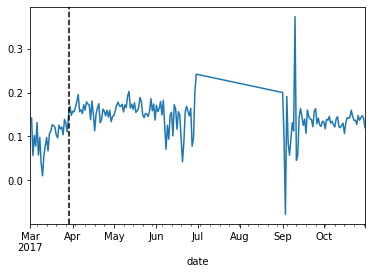

In [28]:
#galaxy_s8 sentiment
print("SAMSUNG GALAXY SENTIMENT(using TextBlob) :")
score_before = df1.loc[(df1['date']<galaxy_s8_date) & (df1['Label']==2)].scores2.mean()
print("average sentiment score before release:",score_before)

score_after = df1.loc[(df1['date']>galaxy_s8_date) & (df1['Label']==2)].scores2.mean()
print("average sentiment score after release:",score_after)

plot_sentiment2(df1[df1['Label']==2],galaxy_s8_date)